In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from ripser import ripser, Rips
import stablerank.srank as sr
import numpy as np

df_brain = pd.read_csv('data/braincancer.csv')
df_breast = pd.read_csv('data/breastcancer.csv')


In [2]:
from tqdm import tqdm

Meta Analysis:

In [3]:
brain_cancer_types = set(df_brain['type'])
breast_cancer_types = set(df_breast['type'])
brain_sample_size = {}
breast_sample_size = {}

for t in brain_cancer_types:
    brain_sample_size[t] = len(df_brain['type'].loc[df_brain['type'] == t])

for t in breast_cancer_types:
    breast_sample_size[t] = len(df_breast['type'].loc[df_breast['type'] == t])

Normalize data

In [35]:
brain_sample_size

{'pilocytic_astrocytoma': 15,
 'normal': 13,
 'medulloblastoma': 22,
 'ependymoma': 46,
 'glioblastoma': 34}

Principle Component Analysis

/Users/00olli01/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


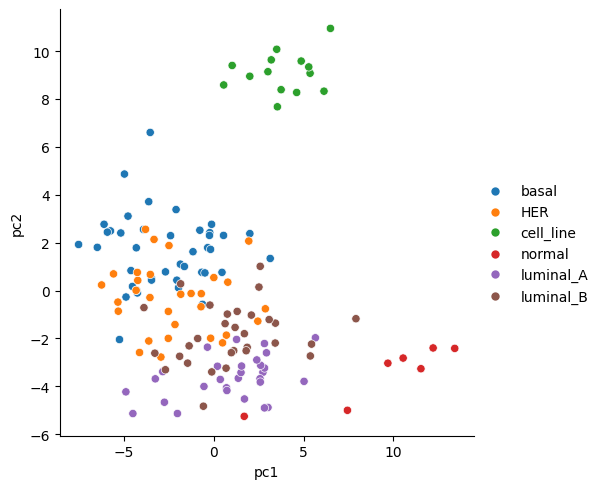

In [53]:
N_components = 130

#Make PCA 
df = df_breast
X = df.drop(columns=['type']).to_numpy()
labels = df['type'].to_numpy()
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)
pca = PCA(n_components=N_components)
principal_components = pca.fit_transform(Xscaled)

#Normalize the principal components
principal_components = (principal_components - principal_components.mean())/principal_components.std()


#Plot values of first two principal components for different cancer types
pltdf = pd.DataFrame({'label': labels, 'pc1': principal_components[:, 0], 'pc2' : principal_components[:, 1]})
sns.relplot(data=pltdf, x='pc1', y='pc2', hue=labels)

Make pandas data frame with all principle components

In [5]:
#Column names:
columns = ["PC" + str(i) for i in range(1,N_components +1)]

#Data frame
df_PCA = pd.DataFrame(principal_components,columns = columns)

df_PCA['type'] = labels

df_PCA

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,type
0,8.053672,0.254158,4.277798,4.736320,0.526316,4.514790,2.340783,-2.658531,-1.220914,-1.771665,...,0.051563,0.084872,0.055873,0.156263,-0.071951,0.053301,-0.257669,0.050814,1.911353e-15,ependymoma
1,4.155915,-2.589906,-3.234330,0.957955,2.715898,-2.068392,0.095552,-0.441696,2.162606,1.833617,...,0.132750,0.017646,-0.054354,-0.030448,0.006063,-0.123789,0.113010,0.082461,1.911353e-15,ependymoma
2,3.426559,-3.330454,-0.231849,-0.528597,1.062781,-1.716262,-0.717824,1.133219,0.737147,-0.107986,...,-0.561730,-0.408704,-0.045252,-0.149419,-1.282413,-0.655828,-0.029834,-0.143430,1.911353e-15,ependymoma
3,-4.953370,-2.325610,-0.923663,2.385606,0.815829,0.921781,-2.646505,-1.398527,0.851861,-0.191563,...,0.044613,0.022911,-0.041704,-0.031749,0.018208,-0.047693,0.082619,0.052988,1.911353e-15,ependymoma
4,3.209003,-2.727816,0.143227,2.655579,0.650313,0.645811,3.222158,-0.341716,0.845977,-2.091417,...,0.118499,-0.186386,-0.134870,0.057260,0.045104,-0.048588,0.015889,-0.043116,1.911353e-15,ependymoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,-5.105154,-1.632315,0.981431,-1.937660,-2.343340,0.208215,2.313106,-0.261858,0.279957,1.154359,...,0.022584,0.249131,0.039731,-0.135259,-0.019780,-0.094935,0.075074,-0.036561,1.911353e-15,pilocytic_astrocytoma
126,-2.076363,-1.226834,0.617623,-0.395460,-0.545003,-1.942823,2.320118,1.333443,0.757577,0.784956,...,-0.067934,-0.054258,-0.052981,-0.018744,-0.063253,-0.004747,-0.116723,-0.021622,1.911353e-15,pilocytic_astrocytoma
127,-5.701900,-1.879964,2.084247,-3.348753,-1.776814,-0.466016,-0.851103,-3.778621,-1.092625,1.284171,...,-0.313186,-0.767526,-0.004198,0.212525,-0.019243,0.152318,-0.140613,0.269697,1.911353e-15,pilocytic_astrocytoma
128,-5.838758,-0.509216,1.800320,-3.178771,-0.536994,0.653692,1.002485,-2.154467,-2.044761,1.787473,...,-0.216280,0.263131,-0.066529,-0.033432,0.208865,-0.068235,0.068240,-0.148516,1.911353e-15,pilocytic_astrocytoma


Feature selection with sklearn.

In [47]:
df = df_breast.drop(columns = ['samples'])
labels = df['type'].to_numpy()
X = df.drop(columns = ['type'])
y = df['type']

#Normalize data
X = X/X.mean()

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=1000)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

df_feature_select = X[featureScores.nlargest(1000,'Score')['Specs']].copy()
df_feature_select['type'] = labels

              Specs      Score
37495     228241_at  27.875218
33137     223861_at  24.171563
46588     237339_at  19.965771
52490     243241_at  19.481923
15824     206378_at  19.413578
37808     228554_at  19.209255
38210     228956_at  18.140522
4681   1559258_a_at  17.532903
14491     205044_at  17.391731
14672     205225_at  16.862104




Method 1: Transpose PCA data and find stable rank for each cancer type. 

Spaces correspond to cancer types.

Points in each space: Values of one principle component for all patients.

Number of points in each space: Number of principle components (constant).

Dimension of each space: Number of patients with corresponding cancer type.

In [48]:
cancer_types = set(labels)
all_data = {}

#We want all spaces to have the same dimension - same number of patients for all spaces
smallest_sample_size = min(breast_sample_size.values())

for cancer_type in cancer_types:
    df = df_PCA.loc[df_PCA['type'] == cancer_type]
    X = df.drop(columns=['type']).head(smallest_sample_size).to_numpy()
    
    #Transpose data
    X = np.transpose(X)
    
    d = squareform(pdist(X, "euclidean"))

    # getting a distance object
    c_dist = sr.Distance(d)

    # getting h0sr
    f = c_dist.get_h0sr(clustering_method = "complete", reduced = False)

    #getting bar codes
    b = c_dist.get_bc(maxdim=2)


    #getting h1sr

    g = sr.bc_to_sr(b, degree="H1")
    h = sr.bc_to_sr(b, degree="H2")
    data = {"H0sr": f, "bar code": b, "H1sr": g, "H2sr": h}
    
    all_data[cancer_type] = data

H0 stable rank plot

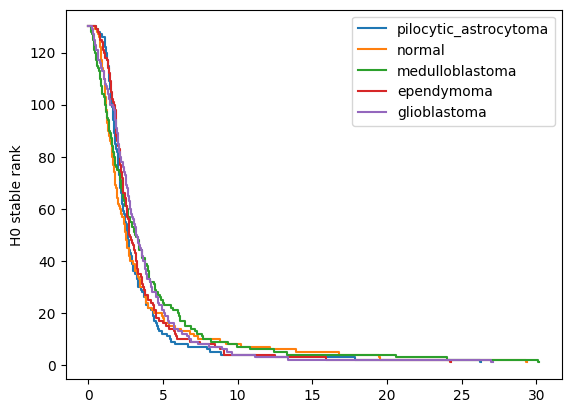

In [11]:
plt.figure()
for cancer_type in cancer_types:
    all_data[cancer_type]["H0sr"].plot(label =cancer_type)

plt.ylabel("H0 stable rank")
plt.legend()
plt.show()

H1 stable rank plot

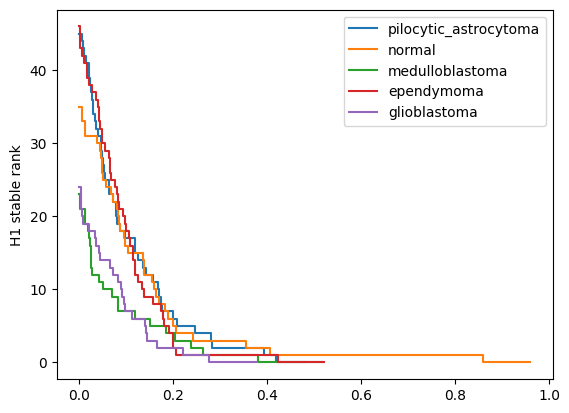

In [12]:
plt.figure()
for cancer_type in cancer_types:
    all_data[cancer_type]["H1sr"].plot(label =cancer_type)

plt.ylabel("H1 stable rank")
plt.legend()
plt.show()

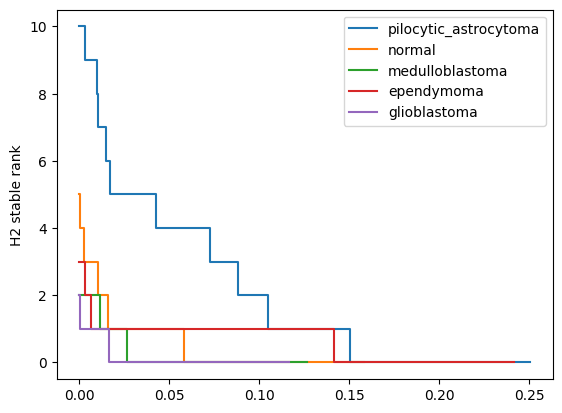

In [13]:
plt.figure()
for cancer_type in cancer_types:
    all_data[cancer_type]["H2sr"].plot(label =cancer_type)

plt.ylabel("H2 stable rank")
plt.legend()
plt.show()

Method 2: Transpose feature selected data and find stable rank for each cancer type. 

Spaces correspond to cancer types.

Points in each space: Values of one principle component for all patients.

Number of points in each space: Number of principle components (constant).

Dimension of each space: Number of patients with corresponding cancer type.

In [56]:
cancer_types = set(labels)
all_data = {}

#We want all spaces to have the same dimension - same number of patients for all spaces
smallest_sample_size = min(breast_sample_size.values())

for cancer_type in tqdm(cancer_types):
    df = df_feature_select.loc[df_feature_select['type'] == cancer_type]
    X = df.drop(columns=['type']).head(smallest_sample_size).to_numpy()
    
    #Transpose data
    X = np.transpose(X)
    
    d = squareform(pdist(X, "euclidean"))

    # getting a distance object
    c_dist = sr.Distance(d)

    # getting h0sr
    f = c_dist.get_h0sr(clustering_method = "complete", reduced = False)

    #getting bar codes
    b = c_dist.get_bc(maxdim=1)


    #getting h1sr

    g = sr.bc_to_sr(b, degree="H1")
    h = 0#sr.bc_to_sr(b, degree="H2")
    data = {"H0sr": f, "bar code": b, "H1sr": g, "H2sr": h}
    
    all_data[cancer_type] = data

100%|███████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.37it/s]


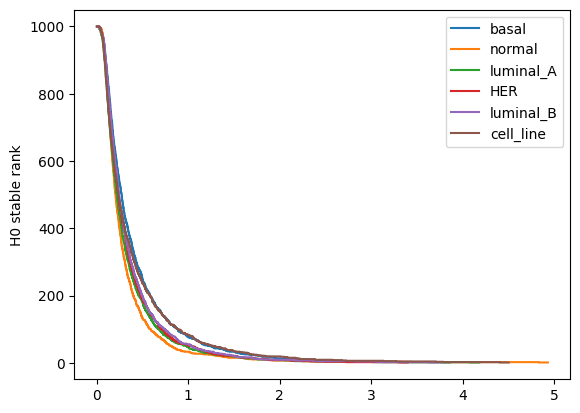

In [57]:

plt.figure()
for cancer_type in cancer_types:
    all_data[cancer_type]["H0sr"].plot(label =cancer_type)

plt.ylabel("H0 stable rank")
plt.legend()
plt.show()

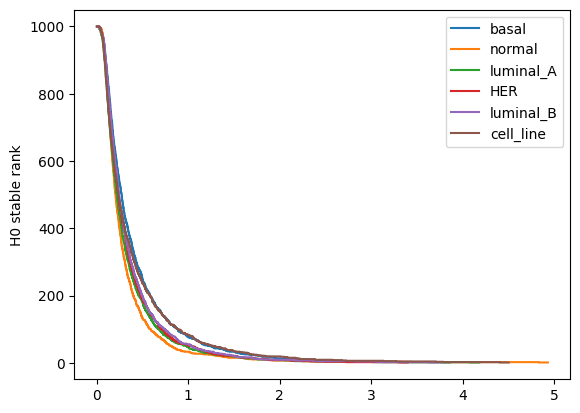

In [58]:
plt.figure()
for cancer_type in cancer_types:
    all_data[cancer_type]["H0sr"].plot(label =cancer_type)

plt.ylabel("H0 stable rank")
plt.legend()
plt.show()

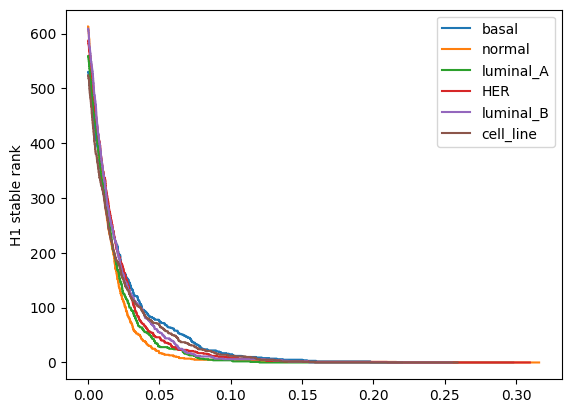

In [59]:
plt.figure()
for cancer_type in cancer_types:
    all_data[cancer_type]["H1sr"].plot(label =cancer_type)

plt.ylabel("H1 stable rank")
plt.legend()
plt.show()

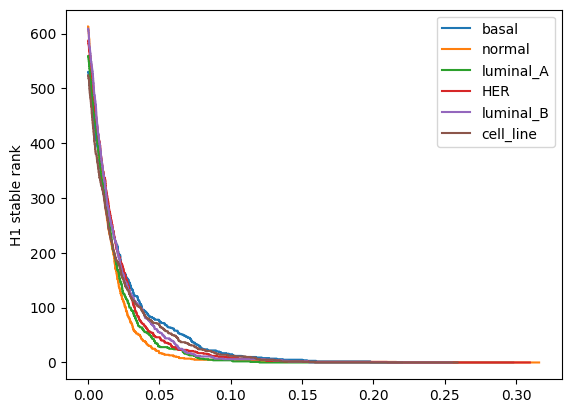

In [60]:
plt.figure()
for cancer_type in cancer_types:
    all_data[cancer_type]["H1sr"].plot(label =cancer_type)

plt.ylabel("H1 stable rank")
plt.legend()
plt.show()

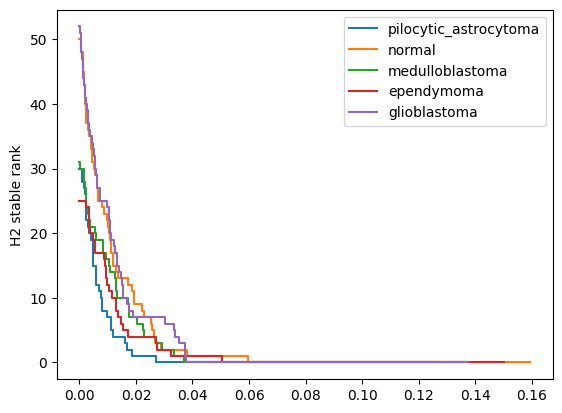

In [28]:
plt.figure()
for cancer_type in cancer_types:
    all_data[cancer_type]["H2sr"].plot(label =cancer_type)

plt.ylabel("H2 stable rank")
plt.legend()
plt.show()